## Logistic Regression Problem
Mathematical formulation:
$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n \log (1 + exp(-y_i a_i^T x)) + \frac{\lambda}{2} \|x\|^2_2
$$ 

In [667]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import sys
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm
from matplotlib.pyplot import figure

In [668]:
def f_logistic(A, y, x, lambd):
    n = A.shape[0]
    f = np.sum(np.log(1+np.exp(-np.dot(A, x) * y)))/(2*n) + (lambd/2)*np.sum(x**2)
    return f

$$
f_i(x) = \frac{1}{2} \log(1+exp(-y_i a^T_i x)) + \frac{\lambda}{2} \|x\|^2
$$
$$
\nabla f_i(x) = \frac{1}{2} \frac{-y_i}{exp(y_i a_i^T x) + 1} a_i + \lambda x
$$

## Logistic Regression Problem
Mathematical formulation:
$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n \log (1 + exp(-y_i a_i^T x)) + \frac{\lambda}{2} \|x\|^2_2
$$ 

In [669]:
def grad_full(A, y, x, lambd):
    n = A.shape[0]
    num = -y
    den = (1 + np.exp(np.dot(A, x) * y))
    c = num/den
    c2 = np.dot(c.T,A)
    final_grad = (c2)/(2*n) + lambd * x
    return final_grad

In [670]:
def grad_f_logistic_i(A, y, x, lambd, random_ind, batch_size=1):
    n = A.shape[0]
    num = -y[random_ind]
    den = (1 + np.exp(np.dot(A[random_ind], x) * y[random_ind]))
    c = num/den
    c2 = np.dot(c.T,A[random_ind])
    final_grad = (c2)/(2*batch_size) + lambd * x
    return final_grad

In [671]:
# def grad_f_logistic_i1(A, y, x, lambd, random_ind, batch_size=1):
#     n = A.shape[0]
#     l = len(random_ind)
#     grad = 0
#     for i in range(l):
#         grad += -y[random_ind[i]]/(1+np.exp(y[random_ind[i]]*np.dot(A[random_ind[i]], x)))/2*A[random_ind[i]] + lambd*x
#     grad = grad/l
#     return grad

In [672]:
def construct_v_independent_sampling(probab):
    n = len(probab)
    v = []
    for i in range(0, n):
        rand = np.random.rand();
        if rand <= probab[i]:
            v.append(i)
    return v

def construct_proper_sampling(n_batch, probab):
    random_ind = np.random.choice(n_batch, p=probab)
    return random_ind


def construct_tau_nice(n, tau):
    random_sample = np.random.choice(np.arange(n), tau, replace=False)
    return random_sample

## Calculating constants

$$
L_i = \frac{1}{8} \| \mathbf{A}(i,:) \|_2^2 + \lambda \ \ \forall i \\
\mu =  \lambda
$$

In [673]:
def calculate_mu_and_L (A, lambd):
    n = A.shape[0]
    mu =  lambd
    L = la.norm(A, axis=1, ord=2)**2/8 + lambd

    return mu, L

In [674]:
def calculate_M(A, lambd):
    n = A.shape[0]
    M = la.norm(A, axis=1, ord=2)**2/8 + lambd
    return M

In [675]:
def calculate_h (A, y, x_star, lambd):
    n = A.shape[0]
    h = [la.norm(grad_f_logistic_i(A, y, x_star, lambd, i))**2 for i in range(n)]

    return h

In [676]:
def calculate_sigma2_proper (probab, h):
    n = len(probab)
    sig = 0
    for i in range(n):
        sig += (1 / probab[i]) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_proper (probab, M):
    n = len(probab)
    L = max([M[i]/probab[i] for i in range(n)])
    L = L/n
    
    return L

In [677]:
def calculate_sigma2_indepedent (probab, h):
    n = len(probab)
    sig = 0

    for i in range(n):
        sig += (1 / probab[i] - 1) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_indepedent (probab, M):
    L = 0
    n = len(probab)
    
    for i in range(n):
        L += M[i]/n
    
    second_term = max([(1 / probab[i] - 1) * M[i]/n for i in range(n)])
    L += second_term
    
    return L

In [678]:
def calculate_sigma2_taunice (h, tau):
    n = len(h)
    sig = 0

    for i in range(n):
        sig += h[i]
    sig = sig/(n*tau)*(n-tau)/(n-1)
    
    return sig

def calculate_L_cal_taunice (M, tau, n):
    L = 0

    for i in range(n):
        L += M[i]/n
        
    L = L/tau*(tau-1)/(n-1)
    
    second_term = max([M[i] for i in range(n)])
    second_term = second_term/tau*(1-(tau-1)/(n-1))
    L += second_term
    
    return L

In [679]:
def calculate_prob_L(M, n, tau):
    pl = np.zeros(n)
    s = sum([M[i] for i in range(n)])
    over = set()
    below = set(range(n))

    for i in range(n):
        pl[i] = M[i] / s * tau
        if pl[i] == 1.0:
            below.discard(i)
        if pl[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = pl[ind] - 1
        length_of_rem = len(below)
        pl[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            pl[below_ind] += rem / length_of_rem
            if (pl[below_ind] > 1.0000000001):
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return pl

In [680]:
def calculate_prob_sigma(h, n, tau):
    ps = np.zeros(n)
    s = sum([abs(np.sqrt(h[i])) for i in range(n)])
    over = set()
    below = set(range(n))
    
    for i in range(n):
        ps[i] = np.sqrt(h[i]) / s * tau
        if ps[i] == 1.0:
            below.discard(i)
        if ps[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = ps[ind] - 1
        length_of_rem = len(below)
        ps[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            ps[below_ind]+= rem / length_of_rem
            if ps[below_ind] > 1.0000000001:
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return ps

In [681]:
def calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu):
    a = 2 * (sum([np.sqrt(h[i]) for i in range(n)])/n)**2 / (epsilon * mu * sum([M[i] for i in range(n)])/n)
#     print(a)
    alpha = (tau - a - 1 + np.sqrt(4 * tau + (tau - a - 1)**2)) / (2 * tau)
    
    pl = calculate_prob_L(M, n, int(alpha*tau))
    ps = calculate_prob_sigma(h, n, int((1-alpha)*tau))
    
#     print(alpha)
    p_opt =  pl +  ps
    
    return p_opt

In [682]:
def calculate_optimal_prob_proper(M, h, n, epsilon, mu):
    pl = calculate_prob_L(M, n, 1)
    ps = calculate_prob_sigma(h, n, 1)
    L_opt = sum([M[i] for i in range(n)])/n
    sig2_opt = (sum([abs(np.sqrt(h[i])) for i in range(n)])/n)**2
    print(sig2_opt)
    alpha = epsilon*mu*L_opt/(2*sig2_opt+epsilon*mu*L_opt)
    print(alpha)
    p_opt = alpha * pl + (1 - alpha) * ps
    
    return p_opt

In [683]:
def calculate_stepsize(L_cal, epsilon, mu, sigma2):
    gamma = min(1 / (2 * L_cal), epsilon * mu / (4 * sigma2))

    return gamma

In [684]:
def calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n):
    k = max(2 * L_cal / mu, 4 * sigma2 / (epsilon * mu**2)) * np.log(2 * la.norm(x0 - x_star)**2 / epsilon)
    return k/n

In [685]:
def calculate_tau_star_independent(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    t = n*(2/(mu*epsilon)*h_bar - L_max)/(2/(mu*epsilon)*h_bar - L_max + sum(L))
    return t
    

In [686]:
def calculate_tau_star_taunice(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    L_bar = sum(L)/n
    
    t = n*(L_bar - L_max + 2/(mu*epsilon)*h_bar)/(n*L_bar - L_max + 2/(mu*epsilon)*h_bar)
    return t
    

In [687]:
def GD(A, y, x0, lambd, step_size, 
        epsilon=1e-10, max_epoch=200000):
    
   
    n = A.shape[0]
    d = A.shape[1]
    
    x = x0
    

    iter_num = 0
    
    n_batch = np.arange(n)
    
    full_grad_adel = grad_full(A, y, x, lambd)
    grad = la.norm(full_grad_adel)**2
    
    while grad > epsilon: 
        full_grad_adel = grad_full(A, y, x, lambd)
        x_new = x - step_size * full_grad_adel
        x = x_new
        iter_num += 1
        grad = la.norm(full_grad_adel)**2
        if (iter_num%20000==0):
            print(grad)
    
    print("Number of epochs:", iter_num)
    print("Grad error:", la.norm(grad_full(A, y, x, lambd))**2 )
    print()
    
    return x

In [688]:
def solution(A, y, lambd):
    n = A.shape[0]
    d = A.shape[1]
    L = la.norm(np.dot(A.T,A)/(8*n)) + lambd

    st_s = 1/(2*L)
    st_s = st_s 
    print(st_s)
    x0 = np.random.randn(d)
    x_opt = GD(A, y, x0, lambd, st_s, 1e-12)
    return x_opt

In [689]:
def construct_v_independent_sampling(probab):
    n = len(probab)
    v = []
    for i in range(0, n):
        rand = np.random.rand();
        if rand <= probab[i]:
            v.append(i)
    return v


def construct_tau_nice(n, tau):
    random_sample = np.random.choice(np.arange(n), tau, replace=False)
    return random_sample

In [690]:
def sgd(A, y, x0, x_star, lambd, probab, step_size, 
        epsilon=1e-6, max_epoch=100, seed=42, kind="proper", tau = 1):
    
    np.random.seed(seed)
    
    n = A.shape[0]
    d = A.shape[1]
    
    x = x0
    
    epoch_num = 0
    iter_num = 0
    
    n_batch = np.arange(n)
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_logistic(A, y, x, lambd)]
    
    while epoch_num < max_epoch and error[-1] > epsilon: 
        

        if (kind == "proper"):
            v = np.random.choice(n_batch, size=n, replace=True, p=probab)
            for i in range(n):
                rand_ind = v[i]
                x = x - step_size * grad_f_logistic_i(A, y, x, lambd, rand_ind)
                iter_num += 1
        elif (kind == "taunice"):
            v = construct_tau_nice(n, tau)
            x_new = x - step_size * grad_f_logistic_i(A, y, x, lambd, v, len(v))
            x = x_new
            iter_num += len(v)
        else:
            v = construct_v_independent_sampling(probab)
            if len(v) == 0:
                x = x
            else:
                x = x - step_size * grad_f_logistic_i(A, y, x, lambd, v, len(v))
            iter_num += len(v)
        

        
        if iter_num >= n :
            f = open("log.txt", "w+")
            f.write(str(epoch_num) + " error: " + str(error[-1]))
            f.close()
            epoch_num += 1
            iter_num = 0
            f_values.append(f_logistic(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)
    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

### Synthetic Data

In [761]:
# np.random.seed(1)

n = 200
d = 10
lambd = 40/n

A = np.random.randn(n, d)
y = np.random.choice([-1, 1], size = n)


A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)


x_star = solution(A, y, lambd)

epsilon = 0.001

tau = int(n/10)

x0 = np.random.normal(size=d)


mu, L = calculate_mu_and_L(A, lambd)
M = calculate_M(A, lambd)
h = calculate_h(A, y, x_star, lambd)


#Real data

# def get_data():
#     data = load_svmlight_file("/home/sailana/Desktop/Real_dataset/w3a")
#     return data[0], data[1]

# A, y = get_data()

# A = A.todense()
# A = np.array(A)

# n = A.shape[0]
# d = A.shape[1]

# # A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# lambd = 100/n
# x_star = solution(A, y, lambd)


# epsilon = 0.001

# tau = int(n/100)

# x0 = np.random.normal(size=d)
# mu, L = calculate_mu_and_L(A, lambd)
# M = calculate_M(A, lambd)
# h = calculate_h(A, y, x_star, lambd)

2.0798693255179437
Number of epochs: 24
Grad error: 1.9308997331347705e-13



In [762]:
n, d

(200, 10)

In [763]:
epoch_num = 130

## Proper, non-vacuous sampling

In [764]:
probab_uniform = np.ones(n)/n
L_cal = calculate_L_cal_proper(probab_uniform, M)
sigma2 = calculate_sigma2_proper(probab_uniform, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 306.4583231004713
Stepsize: 0.0008096160433866209


In [765]:
x_opt_proper, f_val_proper, x_err_proper = sgd(A, y, x0, x_star, lambd, probab_uniform, step_size, 
                          epsilon=epsilon, max_epoch=epoch_num, kind="proper")

Number of epochs: 130
Error: 0.0010607440102471109



#### Proper, non-vacuous sampling, Importance

In [766]:
p_proper_opt = calculate_optimal_prob_proper(M, h, n, epsilon, mu)
L_cal = calculate_L_cal_proper(p_proper_opt, M)
sigma2 = calculate_sigma2_proper(p_proper_opt, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

0.061676054849525486
0.0005266692775296785
Expected number of epochs: 306.05332933948375
Stepsize: 0.0008106873908118381


In [767]:
x_opt_proper_importance, f_val_proper_importance, x_err_proper_importance = sgd(A, y, x0, x_star, lambd, 
                                p_proper_opt, step_size, epsilon=epsilon, max_epoch=epoch_num, kind="proper")

Number of epochs: 130
Error: 0.0012459364486554754



## Independence Sampling

In [768]:
p_uniform = np.ones(n)/n*tau
L_cal = calculate_L_cal_indepedent(p_uniform, M)
sigma2 = calculate_sigma2_indepedent(p_uniform, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 13.790624539521218
Stepsize: 0.017991467630813784


In [769]:
x_opt_indep, f_val_indep, x_err_indep = sgd(A, y, x0, x_star, lambd, p_uniform, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 122
Error: 0.0008820315295084602



### Independence, importance

In [770]:
p_optimal = calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu)
L_cal = calculate_L_cal_indepedent(p_optimal, M)
sigma2 = calculate_sigma2_indepedent(p_optimal, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 14.575778343783183
Stepsize: 0.017022320809188685


In [771]:
x_opt_indep_importance, f_val_indep_importance, x_err_indep_importance = sgd(A, y, x0, x_star, lambd, p_optimal, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 122
Error: 0.0009108312556853241



### Independent, uniform with optimal minibatch

In [772]:
tau_star = calculate_tau_star_independent(h, L, n, mu, epsilon)
tau_star = int(tau_star)
p_uniform_tau = np.ones(n)/n*tau_star
L_cal = calculate_L_cal_indepedent(p_uniform_tau, M)
sigma2 = calculate_sigma2_indepedent(p_uniform_tau, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 0.17025462394470636
Stepsize: 1.4573088780959167


In [773]:
x_opt_indep_tau, f_val_indep_tau, x_err_indep_tau = sgd(A, y, x0, x_star, lambd, p_uniform_tau, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 7
Error: 0.0006079177764848679



### $\tau$-nice sampling

In [774]:
p_uniform_tau = np.ones(n)/n*tau
L_cal = calculate_L_cal_taunice(M, tau, n)
sigma2 = calculate_sigma2_taunice(h, tau)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 13.859924160322832
Stepsize: 0.01790151029265972


In [775]:
x_opt_taunice, f_val_taunice, x_err_taunice = sgd(A, y, x0, x_star, lambd, p_uniform_tau, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="taunice", tau=tau)

Number of epochs: 116
Error: 0.000976282374269959



### $\tau$-nice with optimal $\tau$

In [776]:
taunice_opt = int(calculate_tau_star_taunice(h, L, n, mu, epsilon))
print(taunice_opt)
# taunice_opt = n
L_cal = calculate_L_cal_taunice(M, taunice_opt, n)
sigma2 = calculate_sigma2_taunice(h, taunice_opt)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

181
Expected number of epochs: 0.1616565740000821
Stepsize: 1.5348189614075096


In [777]:
x_opt_taunice_taustar, f_val_taunice_taustar, x_err_taunice_taustar = sgd(A, y, x0, x_star, lambd, np.ones(n)/n, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="taunice", tau=taunice_opt)

Number of epochs: 6
Error: 0.0008494476730057767



In [778]:
from matplotlib.pyplot import figure

In [779]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 15
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 21#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 28#36
plt.rcParams['axes.labelsize'] = 28#24

plt.rc('text', usetex=True)

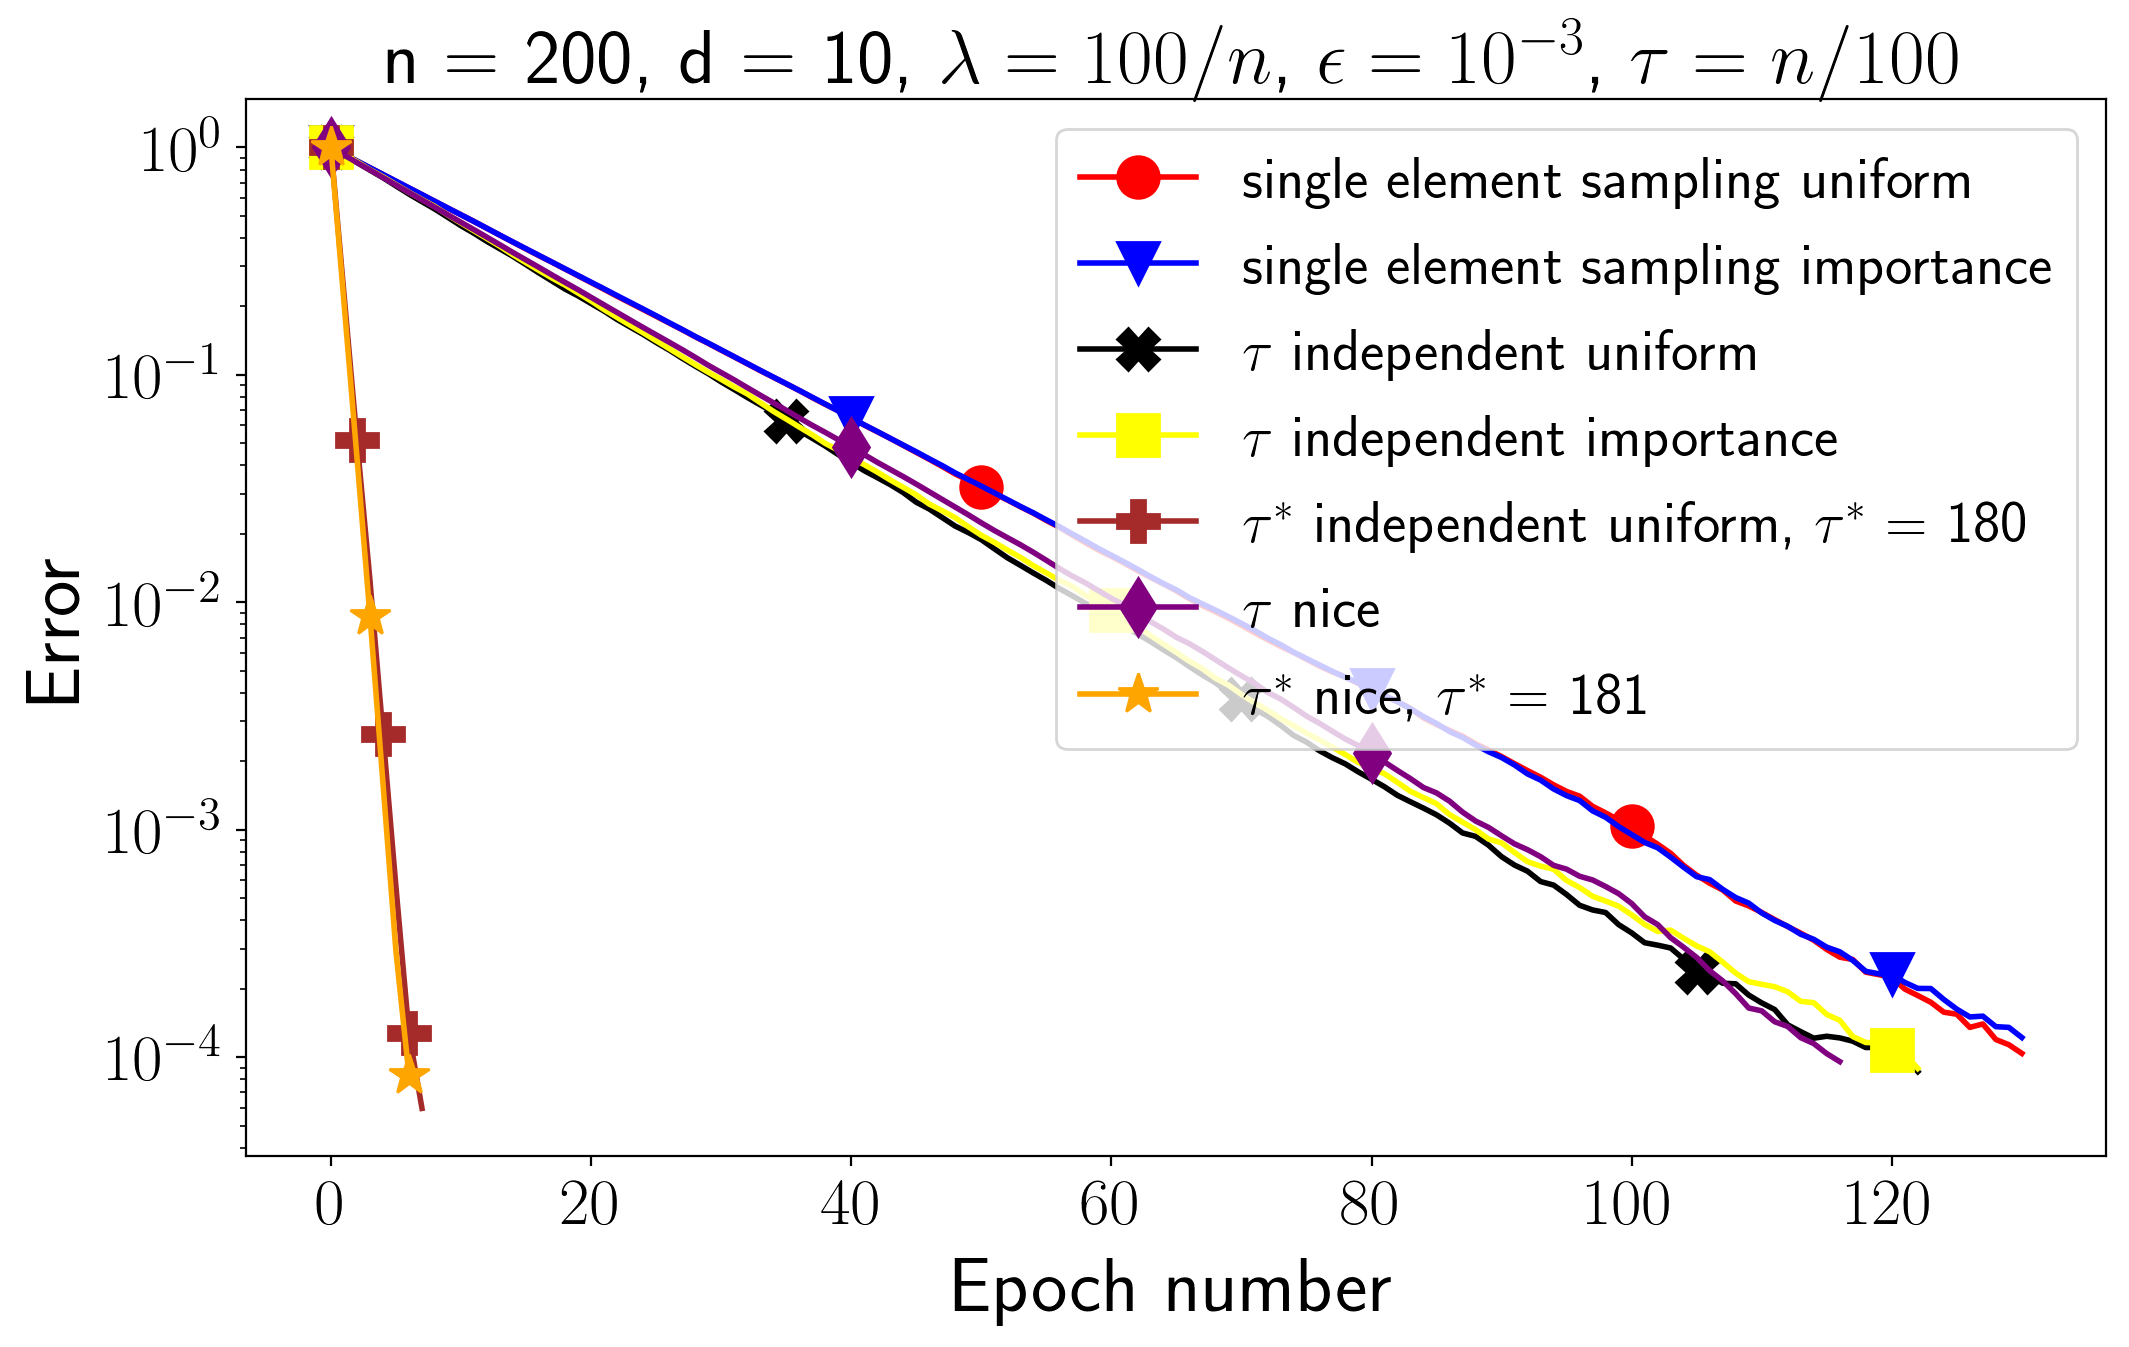

In [791]:
show_range = 1000

figure(num=None, figsize=(12, 7), dpi=200, facecolor='w', edgecolor='k')
plt.semilogy(x_err_proper[0:show_range]/la.norm(x0-x_star)**2, color = 'r',
             marker='o', markevery=50, linewidth=2,
             label=r"single element sampling uniform")
plt.semilogy(x_err_proper_importance[0:show_range]/la.norm(x0-x_star)**2, color = 'blue', 
             marker='v', markevery=40, linewidth=2,
             label=r"single element sampling importance")
plt.semilogy(x_err_indep[0:show_range]/la.norm(x0-x_star)**2, color = 'black', 
             marker='X', markevery=35, linewidth=2,
             label=r"$\tau$ independent uniform")
plt.semilogy(x_err_indep_importance[0:show_range]/la.norm(x0-x_star)**2, color = 'yellow', 
             marker='s', markevery=60, linewidth=2,
             label=r"$\tau$ independent importance")
plt.semilogy(x_err_indep_tau[0:show_range]/la.norm(x0-x_star)**2, color = 'brown', 
             marker='P', markevery=2, linewidth=2,
             label=r"$\tau^*$ independent uniform, $\tau^*$ = %d " %tau_star)
plt.semilogy(x_err_taunice[0:show_range]/la.norm(x0-x_star)**2, color = 'purple', 
             marker='d', markevery=40, linewidth=2,
             label=r"$\tau$ nice ")
plt.semilogy(x_err_taunice_taustar[0:show_range]/la.norm(x0-x_star)**2, color = 'orange', 
             marker='*', markevery=3, linewidth=2,
             label=r"$\tau^*$ nice, $\tau^*$ = %d " %taunice_opt)


plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
# plt.grid()
plt.title(r"n = %d, d = %d, $\lambda = 100/n$, $\epsilon=10^{-3}$, $\tau = n/100$" %(n,d))
plt.xlabel("Epoch number")
plt.ylabel(r"Error")
plt.savefig("n%d_d%d_all_logistic_synthetic_5graphs.pdf" %(n,d))
plt.show()


